In [ ]:
# next steps: design cnn lstm in a bayesian way make new plot and make sure evrything is correct  

In [1]:
pip install pyro-ppl

  Obtaining dependency information for pyro-ppl from https://files.pythonhosted.org/packages/f2/93/59bced321ede6eeb60061f156df8aae3f4832127fe97f4e86c567ad3b9cc/pyro_ppl-1.8.6-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 14.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install yfinance

  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/1b/0f/77716aa9dd84bb1aa5e93c87122af1de89697b6231f6d01d58d4e7c03c14/yfinance-0.2.36-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 44.0 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 5.8 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.0-cp310-cp310-linux_x86_64.whl size=272555 sha256=e775fd7d4f419722aef0f224a7d5481e4ce0580372ae613d75a838d614104bbe
  Stored in directory: /root/.cache/pip/wheels/c7/70/ad/212867e96e7004265a69c4aa5dcff00a95f547a67ba26e7e76
Successfully built peewee
Note: you may need to restart the kernel to use updated packages.


In [3]:
 pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [8]:
#imports 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
import scipy
import torch.nn.functional as nnf
from torch.optim import SGD 

In [4]:
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import yfinance as yf
import matplotlib.pyplot as plt
import time
import fastprogress
import seaborn as sns
from pyro.nn import PyroModule, PyroSample
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:

def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """Run one training epoch.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        optimizer: Torch optimizer object
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over for each
            epoch to draw batches and display training progress

    Returns:
        float, float: Mean loss of this epoch, fraction of correct predictions
            on training set (accuracy)
    """
    epoch_loss = []

    for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
        optimizer.zero_grad()
        model.train()

        # Forward pass
        y_pred = model(x.to(device).float())
        
        # Compute loss
        loss = loss_fn(y_pred, y.to(device).float())

        # Backward pass
        loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(loss.item())

    # Return the mean loss and the accuracy of this epoch
    return np.mean(epoch_loss)


def validate(dataloader, model, loss_fn, device, master_bar):
    """Compute loss, accuracy and confusion matrix on validation set.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over to draw 
            batches and show validation progress

    Returns:
        float, float, torch.Tensor shape (10,10): Mean loss on validation set, 
            fraction of correct predictions on validation set (accuracy)
    """
    epoch_loss = []  

    model.eval()
    with torch.no_grad():
        for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
            # make a prediction on validation set
            y_pred = model(x.to(device).float())

            # Compute loss
            loss = loss_fn(y_pred, y.to(device).float())

            # For plotting the train loss, save it for each sample
            epoch_loss.append(loss.item())

    # Return the mean loss, the accuracy and the confusion matrix
    return np.mean(epoch_loss)


def run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader, val_dataloader, verbose=False):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data
        early_stopper (EarlyStopper, optional): If passed, model will be trained
            with early stopping. Defaults to None.
        verbose (bool, optional): Print information about model training. 
            Defaults to False.

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]

    for epoch in master_bar:
        # Train the model
        epoch_train_loss = train(train_dataloader, optimizer, model, 
                                                  loss_function, device, master_bar)
        # Validate the model
        epoch_val_loss = validate(val_dataloader, model, loss_function, device, master_bar)

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')

    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses


def plot(title, label, train_results, val_results, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None):
    """Plot learning curves.

    Args:
        title (str): Title of plot
        label (str): x-axis label
        train_results (list): Results vector of training of length of number
            of epochs trained. Could be loss or accuracy.
        val_results (list): Results vector of validation of length of number
            of epochs. Could be loss or accuracy.
        yscale (str, optional): Matplotlib.pyplot.yscale parameter. 
            Defaults to 'linear'.
        save_path (str, optional): If passed, figure will be saved at this path.
            Defaults to None.
        extra_pt (tuple, optional): Tuple of length 2, defining x and y coordinate
            of where an additional black dot will be plotted. Defaults to None.
        extra_pt_label (str, optional): Legend label of extra point. Defaults to None.
    """
    
    epoch_array = np.arange(len(train_results)) + 1
    train_label, val_label = "Training "+label.lower(), "Validation "+label.lower()
    
    sns.set(style='ticks')

    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results']
    
    if extra_pt:
        plt.plot(*extra_pt, 'ok')
    if extra_pt_label:
        legend.append(extra_pt_label)
    # END OF YOUR CODE #
        
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')
    plt.show()

In [6]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix >= len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


def multi_time(data, n_input, n_out):
    
    #train = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    X,y = list(), list()
    in_start= 0
    
    for i in range(len(data)):
        
        in_end = in_start + n_input
        out_end = in_end + n_out
        if out_end <= len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
            in_start +=1
    return np.array(X), np.array(y)

        
    

def data_processing(tickers,start, end,  n_steps=1, target = None, multi_step= False, n_input=None, n_out = None):
    
    #tickers: a list of symbols to retrieve from stock market
    # start: starting date
    # end: ending date
    # target: dependent variable
    # n_steps: how many steps should be used to forecast
    # n_input: integer how many days used to make prediction
    # n_out: for how many days to predict
    
    
    data_list = []
   
    
    for symbol in tickers:
        stock_data = yf.download(symbol, start=start, end=end)
        data_close = stock_data.loc[:,"Close"]
        data_norm = (data_close - min(data_close)) / (max(data_close)-min(data_close)) #normalize
        data = data_norm.values.reshape((len(data_norm),1))
        data_list.append(np.array(data))
    
    if target is not None:
        target_data = yf.download(target, start=start, end=end)
        target_close = target_data.loc[:,"Close"]
        target_norm = (target_close - min(target_close)) / (max(target_close)-min(target_close))
        target = target_norm.values.reshape((len(target_norm),1))
      
        stacked_data = np.concatenate(data_list, axis=0)
        dataset = np.append(stacked_data,target ,axis=1)
    
    else:
        dataset = np.concatenate(data_list, axis=0)
        
   
    
    if multi_step and n_input is not None and n_out is not None:
        
        X,y = multi_time(dataset, n_input, n_out)
        
    else:
        
        X,y= split_sequences(dataset, n_steps)
    
    return X,y



In [9]:
X,y = data_processing(['CL=F'],"2000-08-23","2024-01-10",multi_step =True, n_input=60, n_out = 30)
print(X.squeeze().shape, y.shape)
X = X.squeeze()
print(X[1])
print(y[1])

[*********************100%%**********************]  1 of 1 completed

(5781, 60) (5781, 30)
[0.37863548 0.38093157 0.3854144  0.38459438 0.38831186 0.38667178
 0.38820252 0.39049859 0.3967855  0.39886292 0.38995191 0.39760552
 0.39268535 0.39049859 0.39213865 0.40170567 0.40733656 0.40525915
 0.41072602 0.39131863 0.3842117  0.37830747 0.37792479 0.37792479
 0.37136454 0.374426   0.38147827 0.38104091 0.37792479 0.37327795
 0.37437133 0.3800022  0.38694514 0.38694514 0.40307239 0.39733218
 0.38667178 0.38585176 0.38913187 0.38585176 0.39323203 0.39011591
 0.38814784 0.38590642 0.39022525 0.38448504 0.3850864  0.38443036
 0.38721848 0.38361034 0.38393834 0.38535974 0.38831186 0.3877105
 0.39131863 0.39208399 0.39394273 0.3962388  0.40033896 0.39733218]
[0.40033896 0.39826156 0.39787888 0.3992456  0.39913626 0.39295869
 0.39503611 0.39049859 0.38093157 0.37683142 0.36726439 0.36890446
 0.36622569 0.36152418 0.36671771 0.36802976 0.36152418 0.35824406
 0.36343759 0.36781108 0.36316424 0.34605294 0.34813034 0.34884104
 0.35141047 0.3503171  0.34703697 0.3522

In [10]:
x_train, x_test, y_train, y_test = train_test_split(
X, y, test_size=0.1, random_state=42)




In [11]:
class myDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item,label

In [12]:
x_train = torch.tensor(x_train.reshape(x_train.shape[0],x_train.shape[1],1)).float()
y_train = torch.tensor(y_train.reshape(y_train.shape[0],y_train.shape[1],1)).float()
x_test = torch.tensor(x_test.reshape(x_test.shape[0],x_test.shape[1],1)).float()
y_test = torch.tensor(y_test).float()

In [13]:
train_data = myDataset(x_train.reshape(x_train.shape[0],x_train.shape[1],1),y_train)
test_data = myDataset(x_test.reshape(x_test.shape[0],x_test.shape[1],1),y_test)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=2,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=2,shuffle=False)

In [55]:
print(next(iter(train_loader))[0][1])

tensor([[0.5795],
        [0.5733],
        [0.5520],
        [0.5717],
        [0.5854],
        [0.5970],
        [0.5962],
        [0.5992],
        [0.5990],
        [0.5935],
        [0.5917],
        [0.5854],
        [0.5893],
        [0.5912],
        [0.5748],
        [0.5706],
        [0.5840],
        [0.6016],
        [0.6023],
        [0.6097],
        [0.6123],
        [0.5996],
        [0.5962],
        [0.6020],
        [0.6034],
        [0.5882],
        [0.5777],
        [0.5777],
        [0.5772],
        [0.5776],
        [0.5944],
        [0.5956],
        [0.5990],
        [0.5845],
        [0.5822],
        [0.5935],
        [0.6021],
        [0.6019],
        [0.5996],
        [0.5868],
        [0.5969],
        [0.5828],
        [0.5659],
        [0.5666],
        [0.5711],
        [0.5704],
        [0.5917],
        [0.5929],
        [0.5881],
        [0.5906],
        [0.5932],
        [0.5860],
        [0.5976],
        [0.5981],
        [0.6063],
        [0

In [ ]:
class ts_CNN(nn.Module):
    
    def __init__(self):
        super(ts_CNN, self).__init__()
        
        self.feature= nn.Sequential(
        nn.Conv1d(in_channels = 3, out_channels=64, kernel_size = 1),
        nn.ReLU(),
        )
        
        self.result = nn.Sequential(
        nn.Linear(1*64,50),
        nn.ReLU(),
        nn.Linear(50,1))
        
    def forward(self,x):
        
        x = self.feature(x)
        x = torch.flatten(x,1)
        x = self.result(x)
        
        return x.float()

In [15]:
import pyro.distributions as dist
from pyro.nn import PyroSample
class BNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1,prior_scale=0):
        super().__init__()
        assert in_dim > 0 and out_dim > 0 
        #self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        self.layer_1 = PyroModule[nn.Conv1d](in_channels = 60, out_channels=64, kernel_size = 3, padding = 'same')
        self.activation = PyroModule[nn.ReLU]()
        self.linear_1 = PyroModule[nn.Linear](64, 50)
        self.linear_2 = PyroModule[nn.Linear](50,30)
        
        self.layer_1.weight = PyroSample(dist.Normal(0, 1).expand([64,60,1]).to_event(3))
        self.layer_1.bias = PyroSample(dist.Normal(0, 1).expand([64]).to_event(1))
        self.linear_1.weight = PyroSample(dist.Normal(0, 1).expand([50,64]).to_event(2))
        self.linear_1.bias = PyroSample(dist.Normal(0, 1).expand([50]).to_event(1))
        self.linear_2.weight = PyroSample(dist.Normal(0, 1).expand([30,50]).to_event(2))
        self.linear_2.bias = PyroSample(dist.Normal(0, 1).expand([30]).to_event(1))
    
    def forward(self, x, y = None):
        
        x = self.activation(self.layer_1(x))
        x = torch.flatten(x,1)
        x = self.activation(self.linear_1(x))
        mu = self.linear_2(x)
        #print(mu.shape)
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1)) 
        
        if y is not None:
            y = torch.flatten(y,1)
        
        with pyro.plate("data", x.shape[0]):
            
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma).to_event(1), obs = y)
            #print(obs)
            #print(obs.shape)
        return mu
        


In [16]:
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from tqdm.auto import trange

pyro.clear_param_store()

model = BNN()
mean_field_guide = AutoDiagonalNormal(model)
optimizer = pyro.optim.Adam({"lr": 0.01})

svi = SVI(model, mean_field_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 2
progress_bar = trange(num_epochs)


for epoch in progress_bar:
    loss = 0
    for batch_id, data in enumerate(train_loader):
        loss += svi.step(data[0], data[1])
    progress_bar.set_postfix(loss=f"{loss / 5000:.3f}")


  0%|          | 0/2 [00:00<?, ?it/s]

In [34]:
torch.transpose(x_test[0],1,0).shape

torch.Size([1, 60])

In [18]:
from pyro.infer import Predictive
predictive = Predictive(model, guide=mean_field_guide, num_samples=500)
for batch_id, data in enumerate(test_loader):
        output= model(data[0])
        preds = predictive(data[0])
        print(output, preds)
        break

tensor([[ 125.7870,   16.2788, -322.9535,  249.0552,   -5.7916,  -25.2369,
          275.8015,  224.5074,  283.6084,   21.9004, -206.9620,  -18.2551,
          -77.1448,  -92.8689,  -18.9121,  335.4820, -239.7237,   97.5406,
           96.4887,  101.9081,  201.9247,  -43.0860,  -89.1486, -179.6485,
          -64.9063,  -21.5585,  -13.1717,  140.6794,  -10.2873,    6.6917],
        [  77.4864,    3.2327, -170.1674,  140.4631,   -6.3074,   -8.7342,
          120.7877,  101.7252,  129.2887,   39.6154,  -98.2401,   -3.5998,
          -44.2082,  -61.4833,  -18.5504,  174.7916, -117.0984,   64.5220,
           63.2889,   35.1868,   69.2965,  -24.9328,  -78.2159,  -93.1294,
          -46.4657,   -0.6281,  -16.3176,   60.0124,   15.0944,   22.8557]]) {'layer_1.weight': tensor([[[[[-5.5279e-02],
           [-9.1297e-02],
           [-4.7418e-01],
           ...,
           [-2.1092e-01],
           [-1.3207e-01],
           [-4.0614e-01]],

          [[-3.0853e-02],
           [-3.1227e-01],
  

In [77]:


#for i, data in enumerate()
#preds = predictive(x_test[0])


In [65]:
model(next(iter(train_loader))[0][1])

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x1 and 64x50)

In [75]:
g1 =mean_field_guide(None,None)
g1.data(x_test[0])

AttributeError: 'dict' object has no attribute 'data'

In [ ]:
model.data

In [ ]:
num_samples = 10
def predict(x):
    sampled_models = [mean_field_guide(None, None) for _ in range(num_samples)]
    print(sampled_models)
    yhats = [model(x) for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return mean

predict(x_test[0])

In [ ]:
from pyro.nn.module import to_pyro_module_
import pyro.distributions as dist

model = nn.Sequential(
    nn.Linear(28 * 28, 100),
    nn.Sigmoid(),
    nn.Linear(100, 100),
    nn.Sigmoid(),
    nn.Linear(100, 10),
)
to_pyro_module_(model)
assert isinstance(model, PyroModule[nn.Sequential])
assert isinstance(model[0], PyroModule[nn.Linear])

# Now we can attempt to be fully Bayesian:
for m in model.modules():
    for name, value in list(m.named_parameters(recurse=False)):
        setattr(m, name, PyroSample(prior=dist.Normal(0, 1)
                                              .expand(value.shape)
                                              .to_event(value.dim())))
        print(value.shape)
guide = AutoDiagonalNormal(model)



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ts_CNN()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss = nn.MSELoss()

In [ ]:
train_data = myDataset(train_x.reshape(train_x.shape[0],train_x.shape[1],1),train_y)
valid_data = myDataset(valid_x.reshape(valid_x.shape[0],valid_x.shape[1],1),valid_y)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=2,shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid_data,batch_size=2,shuffle=False)

In [ ]:
x_train = torch.tensor(train_x.reshape(train_x.shape[0],train_x.shape[1],1)).float()
y_train = torch.tensor(train_y).float()
x_test = torch.tensor(valid_x.reshape(valid_x.shape[0],valid_x.shape[1],1)).float()
test_y = torch.tensor(valid_y).float()

In [ ]:
testloader=torch.utils.data.DataLoader(x_test, batch_size=2, shuffle=False)

In [ ]:
x_test = torch.tensor(x_test.reshape(x_test.shape[0],x_test.shape[1],1)).float()
x_test[5].shape


In [ ]:
next(iter(test_loader))[0]

In [ ]:
list(pyro.get_param_store().items())

In [130]:

from pyro.infer import Predictive
predictive = Predictive(model, guide=mean_field_guide, num_samples=500)

#for i, data in enumerate()
preds = predictive(x_test[1])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x1 and 64x50)
       Trace Shapes:          
        Param Sites:          
       Sample Sites:          
 layer_1.weight dist | 64 60 1
               value | 64 60 1
   layer_1.bias dist | 64     
               value | 64     
linear_1.weight dist | 50 64  
               value | 50 64  
  linear_1.bias dist | 50     
               value | 50     

In [ ]:
target_x , target_y = split_sequence(valid_set,3)
inputs = target_x.reshape(target_x.shape[0],target_x.shape[1],1)



In [ ]:
# fürs normale CNN
model.eval()
prediction = []
batch_size = 2
iterations =  int(inputs.shape[0]/2)

for i in range(iterations):
    preds = model(torch.tensor(inputs[batch_size*i:batch_size*(i+1)]).float().to(device))
    prediction.append(preds.detach().cpu().tolist())

In [ ]:
prediction = np.array(prediction).ravel()

In [39]:
preds['obs'][499]

tensor([[0.4550, 0.6230, 0.5328, 0.3277, 0.7926, 0.5648, 0.4590, 0.5583, 0.6486,
         0.4709, 0.7602, 0.6444, 0.5299, 0.3512, 0.5774, 0.6365, 0.8183, 0.7430,
         0.6366, 0.6940, 0.5952, 0.6400, 0.3827, 0.5833, 0.3735, 0.4852, 0.6309,
         0.5082, 0.3566, 0.6108],
        [0.3114, 0.4594, 0.4931, 0.4653, 0.6427, 0.6773, 0.2999, 0.6703, 0.6062,
         0.5839, 0.5647, 0.5714, 0.4332, 0.5860, 0.7183, 0.6549, 0.4911, 0.5934,
         0.5281, 0.3996, 0.7018, 0.6649, 0.8272, 0.6784, 0.5618, 0.5350, 0.7601,
         0.6649, 0.7194, 0.5150]])

In [41]:
preds['obs'][:,0,:].detach().numpy().sum(axis=0)/500

array([0.5337707 , 0.5058664 , 0.5882776 , 0.5084146 , 0.60286576,
       0.58878523, 0.57005054, 0.54155266, 0.58992606, 0.51274663,
       0.53840595, 0.5135027 , 0.49600688, 0.52959734, 0.5952513 ,
       0.5252082 , 0.537766  , 0.5381802 , 0.5428346 , 0.5441912 ,
       0.5363558 , 0.61066765, 0.54113305, 0.6158426 , 0.54043883,
       0.5187796 , 0.5377378 , 0.6215734 , 0.51009625, 0.6015029 ],
      dtype=float32)

In [55]:
y_std = preds['obs'][:,0,:].detach().numpy().std(axis=0, ddof=1)
y_pred = preds['obs'][:,0,:].detach().numpy().sum(axis=0)/500
print(y_pred, y_std)

plus_error = y_pred - 2 * y_std
minus_error = y_pred + 2 * y_std
#x_line = range(0,46)


[0.5337707  0.5058664  0.5882776  0.5084146  0.60286576 0.58878523
 0.57005054 0.54155266 0.58992606 0.51274663 0.53840595 0.5135027
 0.49600688 0.52959734 0.5952513  0.5252082  0.537766   0.5381802
 0.5428346  0.5441912  0.5363558  0.61066765 0.54113305 0.6158426
 0.54043883 0.5187796  0.5377378  0.6215734  0.51009625 0.6015029 ] [0.13408753 0.1377123  0.13850896 0.13706064 0.13100559 0.14295132
 0.14124186 0.145193   0.13872823 0.14637664 0.14134371 0.13261802
 0.14071456 0.14436781 0.14094105 0.14370649 0.13638017 0.14569162
 0.15415934 0.13383584 0.14096794 0.13758487 0.1381161  0.13200991
 0.13405925 0.13763648 0.13666402 0.13525516 0.14746311 0.13385734]


In [59]:

print(plus_error)
print(minus_error)

[0.26559561491012573, 0.23044180870056152, 0.3112596571445465, 0.23429334163665771, 0.34085458517074585, 0.302882581949234, 0.28756681084632874, 0.2511666715145111, 0.31246960163116455, 0.21999335289001465, 0.25571852922439575, 0.24826666712760925, 0.21457776427268982, 0.240861713886261, 0.3133692145347595, 0.23779520392417908, 0.2650056481361389, 0.24679693579673767, 0.23451590538024902, 0.2765195071697235, 0.2544199228286743, 0.3354979157447815, 0.2649008333683014, 0.35182276368141174, 0.27232033014297485, 0.24350661039352417, 0.26440975069999695, 0.351063072681427, 0.2151700258255005, 0.3337882161140442]
[0.8019457459449768, 0.7812910079956055, 0.8652955293655396, 0.7825359106063843, 0.864876925945282, 0.874687910079956, 0.852534294128418, 0.831938624382019, 0.8673825263977051, 0.8054999113082886, 0.8210933804512024, 0.7787387371063232, 0.7774360179901123, 0.8183329701423645, 0.8771334290504456, 0.8126211166381836, 0.8105263113975525, 0.8295633792877197, 0.8511532545089722, 0.811862

In [52]:
target_y= y_test[0]

In [72]:
y_train.numpy().unsqueeze().tolist()

AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'

ValueError: x and y can be no greater than 2D, but have shapes (5202,) and (5202, 30, 1)

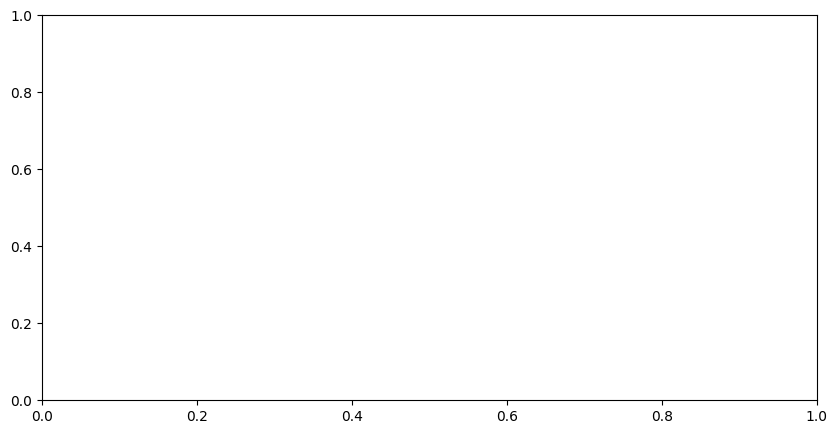

In [66]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(len(y_train.numpy().tolist())),y_train.numpy().tolist())
ax.plot(y_pred, '-', linewidth=3, color="#408765", label="predictive mean")
ax.plot(target_y, '-', linewidth=3, color="r", label="predictive mean")
ax.fill_between(plus_error, minus_error, alpha=0.6, color='#86cfac', zorder=5)